In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import * 
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.models import load_model

2024-08-21 04:26:22.242520: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 04:26:22.242631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 04:26:22.375727: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Histopathologic Cancer Detection Kaggle Competition

This project is part of a kaggle competition with a goal to identify cancer from images of cells. The data supplied by Kaggle is a modified version of the PatchCamelyon (PCam) benchmark dataset with duplicates removed. Training data is supplied with labels for each photo id. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue.

## EDA

To begin we can do some basic exploration of our data. We will also display a few sample images to get an idea of what our data looks like.

In [3]:
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

train_labels.info()
train_labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'
train_dir = '/kaggle/input/histopathologic-cancer-detection/train'

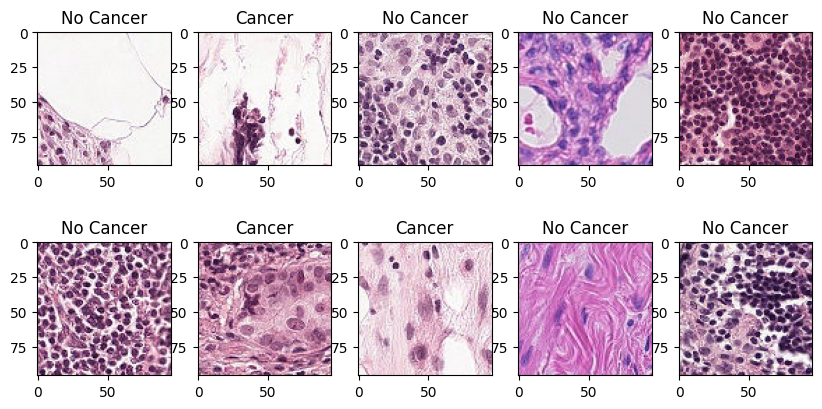

In [5]:
sample_ids = train_labels['id'].head(10)
sample_labels = train_labels['label'].head(10)

plt.figure(figsize=(10,5))
for i, (sid, slab) in enumerate(zip(sample_ids, sample_labels)):
    if slab == 1:
        cancerous = "Cancer"
    else:
        cancerous = 'No Cancer'
    img = train_dir + '/'+sid + '.tif'
    img = Image.open(img)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(cancerous)
plt.show()
    


label
0    130908
1     89117
Name: count, dtype: int64


<Axes: xlabel='label', ylabel='count'>

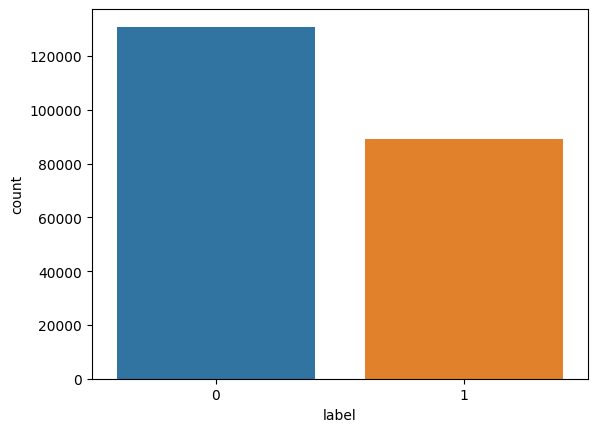

In [6]:
val_counts = train_labels['label'].value_counts()
print(val_counts)
sns.countplot(data=train_labels, x = 'label')

## Data Prep

Before training our model, we will prep our data so that it is in a workable format. We need to make sure that we have the filepath of each file alongisde its corresponding label. We will also set up training and validation data.

In [7]:
img_path = '/kaggle/input/histopathologic-cancer-detection/train'


In [8]:
def join_path(file_id):
    path = os.path.join('/kaggle/input/histopathologic-cancer-detection/train', file_id+ '.tif')
    return path

In [9]:

train_labels['filepath'] = train_labels['id'].apply(join_path)
train_labels['label'] = train_labels['label'].astype('string')

train_labels.head()

,id,label,filepath
0,f38a6374c348f90b587e046aac6079959adf3835,0,/kaggle/input/histopathologic-cancer-detection...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/kaggle/input/histopathologic-cancer-detection...
2,755db6279dae599ebb4d39a9123cce439965282d,0,/kaggle/input/histopathologic-cancer-detection...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/kaggle/input/histopathologic-cancer-detection...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,/kaggle/input/histopathologic-cancer-detection...


In [10]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255, validation_split = 0.2)

In [11]:
train_gen =  datagen.flow_from_dataframe(
    shuffle = True,
    dataframe = train_labels,
    x_col = "filepath",
    y_col = "label",
    target_size = (96, 96),
    color_mode = "rgb",
    batch_size = 32,
    class_mode = "binary",
    subset = "training",
    validate_filenames = False,
    seed = 123
)

Found 176020 non-validated image filenames belonging to 2 classes.


In [12]:
val_gen =  datagen.flow_from_dataframe(
    shuffle = True,
    dataframe = train_labels,
    x_col = "filepath",
    y_col = "label",
    target_size = (96, 96),
    color_mode = "rgb",
    batch_size = 32,
    class_mode = "binary",
    subset = "validation",
    validate_filenames = False,
    seed = 123
)

Found 44005 non-validated image filenames belonging to 2 classes.


In [13]:
test_df = pd.DataFrame()
test_df['filepath'] = [test_dir + '/' + path for path in os.listdir(test_dir)]

test_df.head()

,filepath
0,/kaggle/input/histopathologic-cancer-detection...
1,/kaggle/input/histopathologic-cancer-detection...
2,/kaggle/input/histopathologic-cancer-detection...
3,/kaggle/input/histopathologic-cancer-detection...
4,/kaggle/input/histopathologic-cancer-detection...


In [14]:
test_gen = datagen.flow_from_dataframe(
    shuffle = False,
    dataframe = test_df,
    x_col = "filepath",
    y_col = None,
    target_size = (96, 96),
    color_mode = "rgb",
    batch_size = 32,
    class_mode = None,
    validate_filenames = False,
    seed = 123
)

Found 57458 non-validated image filenames.


## Build a Model

To get started we will try building a model. This model was built by referencing various Tensorflow CNN tutorials, with adjustments made to fit this problem. Admittedly, this may not be the best model for this problem, but it is a starting place to see how it is doing.

In [15]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(96,96,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation ='sigmoid'))


model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 94, 94, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 94, 94, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 45, 45, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    15,860,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,926,305 (60.75 MB)

 Trainable params: 15,926,305 (60.75 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizers.RMSprop(learning_rate=0.0001),loss='binary_crossentropy',metrics=["accuracy"])

In [17]:
step_size_train =train_gen.n//train_gen.batch_size
step_size_val =val_gen.n//val_gen.batch_size
step_size_test =test_gen.n//test_gen.batch_size

In [18]:
h = model.fit(x =train_gen,
          steps_per_epoch=step_size_train,
          validation_data=val_gen,
          validation_steps=step_size_val,
          epochs=10
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-08-21 04:26:45.899797: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9216: 3.69436, expected 2.9656
2024-08-21 04:26:45.899856: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9217: 4.8509, expected 4.12214
2024-08-21 04:26:45.899866: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9218: 5.13563, expected 4.40686
2024-08-21 04:26:45.899874: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9219: 3.87565, expected 3.14689
2024-08-21 04:26:45.899882: E external/local_xla/xla/service/gpu/buffer_compar

   1/5500 ━━━━━━━━━━━━━━━━━━━━ 17:26:22 11s/step - accuracy: 0.4375 - loss: 0.6937

I0000 00:00:1724214411.663040      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4211/5500 ━━━━━━━━━━━━━━━━━━━━ 4:11 195ms/step - accuracy: 0.7537 - loss: 0.5145

2024-08-21 04:40:36.828326: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27648: 2.96086, expected 2.5391
2024-08-21 04:40:36.828395: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27743: 3.1348, expected 2.71304
2024-08-21 04:40:36.828405: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27840: 3.12905, expected 2.70728
2024-08-21 04:40:36.828422: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30048: 3.07607, expected 2.65431
2024-08-21 04:40:36.828432: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30528: 2.96668, expected 2.54492
2024-08-21 04:40:36.828441: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30720: 2.97292, expected 2.55116
2024-08-21 04:40:36.828469: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 35616: 3.0538, expected 2.63204
2024-08-21 04:40:36.828480: E 

5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1331s 240ms/step - accuracy: 0.7601 - loss: 0.5061 - val_accuracy: 0.8092 - val_loss: 0.4277
Epoch 2/10
   1/5500 ━━━━━━━━━━━━━━━━━━━━ 1:14 13ms/step - accuracy: 0.8750 - loss: 0.3238

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-08-21 04:48:51.849433: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27648: 3.14101, expected 2.56892
2024-08-21 04:48:51.849498: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27658: 4.12144, expected 3.54934
2024-08-21 04:48:51.849507: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27659: 4.30373, expected 3.73164
2024-08-21 04:48:51.849516: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27662: 4.6863, expected 4.1142
2024-08-21 04:48:51.849524: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27677: 4.71378, exp

5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1s 135us/step - accuracy: 0.8750 - loss: 0.3238 - val_accuracy: 0.6000 - val_loss: 0.5761
Epoch 3/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 438s 80ms/step - accuracy: 0.8013 - loss: 0.4528 - val_accuracy: 0.8093 - val_loss: 0.4391
Epoch 4/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step - accuracy: 0.7812 - loss: 0.4981 - val_accuracy: 0.4000 - val_loss: 0.7476
Epoch 5/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 303s 55ms/step - accuracy: 0.8013 - loss: 0.4572 - val_accuracy: 0.8027 - val_loss: 0.4619
Epoch 6/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step - accuracy: 0.7500 - loss: 0.3681 - val_accuracy: 1.0000 - val_loss: 0.0755
Epoch 7/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 312s 57ms/step - accuracy: 0.8011 - loss: 0.4634 - val_accuracy: 0.7992 - val_loss: 0.4521
Epoch 8/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step - accuracy: 0.7188 - loss: 0.5517 - val_accuracy: 0.8000 - val_loss: 0.3180
Epoch 9/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 358s 65ms/step - accuracy: 0.7617 - loss: 0.5075

In [19]:
# model.evaluate(val_gen)

In [20]:
def merge_history(hlist):
    history = {}
    for k in hlist[0].history.keys():
        history[k] = sum([h.history[k] for h in hlist], [])
    return history

def vis_training(h, start=1):
    epoch_range = range(start, len(h['loss'])+1)
    s = slice(start-1, None)

    plt.figure(figsize=[14,4])

    n = int(len(h.keys()) / 2)

    for i in range(n):
        k = list(h.keys())[i]
        plt.subplot(1,n,i+1)
        plt.plot(epoch_range, h[k][s], label='Training')
        plt.plot(epoch_range, h['val_' + k][s], label='Validation')
        plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

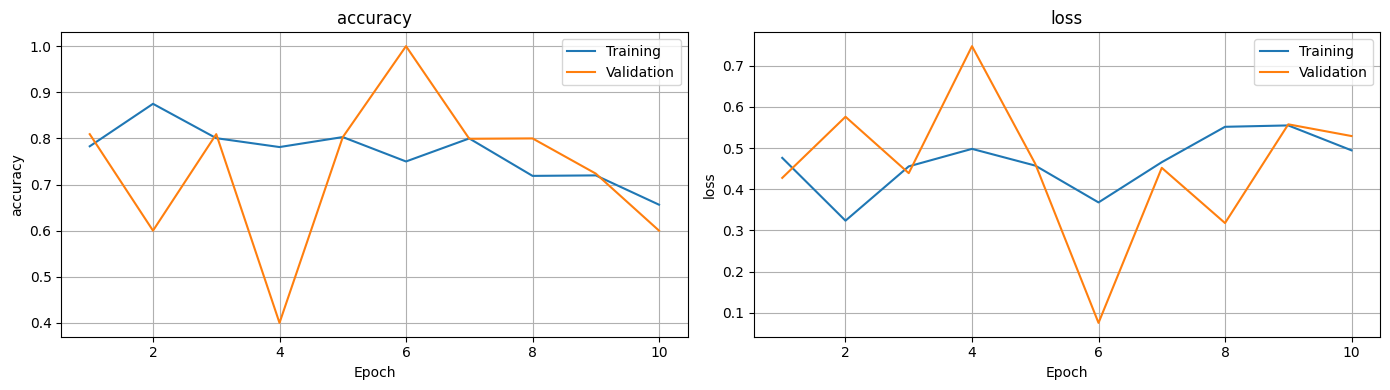

In [21]:
hist1 = merge_history([h])
vis_training(hist1)

In [22]:
model_path = '/kaggle/working/models'
os.makedirs(model_path, exist_ok = True)

model1_path = os.path.join(model_path, 'model1.keras')

model.save(model1_path)

In [23]:
savedModel=load_model('/kaggle/working/models/model1.keras')

In [24]:
preds = savedModel.predict(test_gen)

1795/1796 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step

2024-08-21 05:20:12.314442: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.18121, expected 3.53281
2024-08-21 05:20:12.314530: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.34812, expected 4.69972
2024-08-21 05:20:12.314545: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.25186, expected 4.60346
2024-08-21 05:20:12.314563: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.38196, expected 4.73355
2024-08-21 05:20:12.314581: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.23772, expected 4.58932
2024-08-21 05:20:12.314596: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 5.3595, expected 4.71109
2024-08-21 05:20:12.314607: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 4.76545, expected 4.11704
2024-08-21 05:20:12.314618: E external/local_xla/xla/se

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 443s 247ms/step


In [25]:
preds

array([[0.34689894],
       [0.08566944],
       [0.4208987 ],
       ...,
       [0.53488183],
       [0.14365557],
       [0.3664266 ]], dtype=float32)

In [26]:
labels = np.round(preds)

test_ids = os.listdir('/kaggle/input/histopathologic-cancer-detection/test')


labels = labels.reshape(-1)

submission = pd.DataFrame({'id': test_ids, 'label': labels})

submission['id'] = submission['id'].str.replace('.tif','')
submission['label'] = submission['label'].astype(int)

submission.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,1


In [27]:
submission_file = submission.to_csv('submission.csv', index = False)

This model was submitted to the competition, and it did not do very well. The model only achieved a .5 accuracy - which is no better that guessing. There may be an issue with this model, and certainly it would need to be improved to accurately detect cancer.

## Second Model - ResNet50 with Transfer learning

Our second approach will be to utilize the ResNet50 model, and utilize transfer learning to address our cancer detection challenge. 

In [28]:
from tensorflow.keras.applications import ResNet50

base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    input_shape=(96,96,3),
    include_top=False,
)

base_model.trainable = False #freeze weights

inputs = keras.Input(shape=(96, 96, 3))

x = base_model(inputs, training=False) # running in inference mode

x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)
model2 = keras.Model(inputs, outputs)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:
model2.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

h2 = model2.fit(x =train_gen,
          steps_per_epoch=step_size_train,
          validation_data=val_gen,
          validation_steps=step_size_val,
          epochs=8
)

Epoch 1/8
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 488s 86ms/step - accuracy: 0.6144 - loss: 0.6483 - val_accuracy: 0.6640 - val_loss: 0.6062
Epoch 2/8
   1/5500 ━━━━━━━━━━━━━━━━━━━━ 1:44 19ms/step - accuracy: 0.7500 - loss: 0.5420

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 3s 579us/step - accuracy: 0.7500 - loss: 0.5420 - val_accuracy: 0.4000 - val_loss: 0.9820
Epoch 3/8
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 366s 66ms/step - accuracy: 0.6664 - loss: 0.6081 - val_accuracy: 0.6908 - val_loss: 0.5904
Epoch 4/8
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - accuracy: 0.6562 - loss: 0.6317 - val_accuracy: 0.8000 - val_loss: 0.4428
Epoch 5/8
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 326s 59ms/step - accuracy: 0.6796 - loss: 0.5980 - val_accuracy: 0.6865 - val_loss: 0.5851
Epoch 6/8
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - accuracy: 0.6250 - loss: 0.6700 - val_accuracy: 0.8000 - val_loss: 0.9083
Epoch 7/8
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 308s 56ms/step - accuracy: 0.6832 - loss: 0.5929 - val_accuracy: 0.7033 - val_loss: 0.5780
Epoch 8/8
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step - accuracy: 0.7500 - loss: 0.5363 - val_accuracy: 0.6000 - val_loss: 0.4742


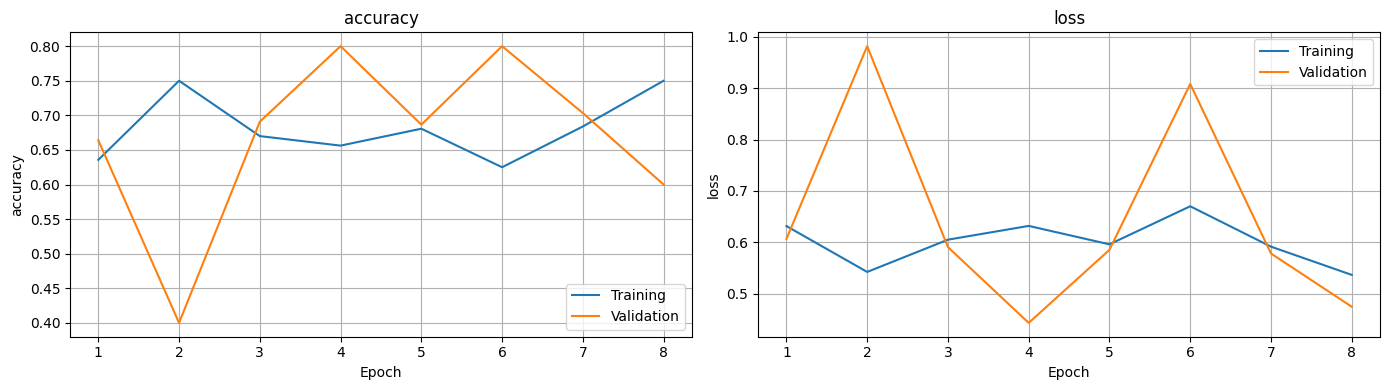

In [30]:
hist2 = merge_history([h2])
vis_training(hist2)

In [31]:

model2_path = os.path.join('/kaggle/working/models', 'model2.keras')

model2.save(model2_path)

In [32]:
savedModel2 = load_model(model2_path)

In [33]:
preds2 = savedModel2.predict(test_gen)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 134s 73ms/step


In [34]:
preds2

array([[0.07923985],
       [0.25309125],
       [0.5394702 ],
       ...,
       [0.6926958 ],
       [0.09219953],
       [0.36004174]], dtype=float32)

In [35]:
labels = np.round(preds2)

test_ids = os.listdir('/kaggle/input/histopathologic-cancer-detection/test')

labels = labels.reshape(-1)

submission = pd.DataFrame({'id': test_ids, 'label': labels})

submission['id'] = submission['id'].str.replace('.tif','')
submission['label'] = submission['label'].astype(int)

submission.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,1
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


In [36]:
submission_file = submission.to_csv('submission.csv', index = False)

In [37]:
submission['label'].value_counts()

label
0    37347
1    20111
Name: count, dtype: int64

## Conclusion

In this project, we have tried two seperate models to detect cancer in cell images. This project is interesting because it shows a clear use case in which machine learning and computer vision can be used to make a positive impact on healthcare.

The first model we experimented with was not successful - this model likely needs to some redesigning, and may require a different number of epocs as well. Our second model, which built off of ResNet50 with transfer learning was slightly more successful with a score of .6601. While this still isn't great, it demonstrates how machine learning can be used in such a medical diagnostic process. This approach also demonstrates how utilizing a base model with transfer learning can be a useful approach to quickly building a model. I think that with some additional layers or alterations to our model design, we could create a ResNet50 based model with better accuracy. Utilization of a different model as a base for transfer learning would also be interesting to experiment with in the future.